In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NPROC'] = '1'
os.environ['JAX_ENABLE_X64'] = 'True'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import h5py
from astropy.cosmology import Planck15

import jax
import jax.numpy as jnp
import numpyro
import equinox
import optax
import jax_tqdm

from flowjax.distributions import StandardNormal
from flowjax.flows import block_neural_autoregressive_flow

In [2]:
file = (
    '/home/matthew.mould/lvk-data/GWTC-3/VT/'
    'o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5'
)

far_cut = 1
snr_cut = 10

injections = {}

with h5py.File(file, 'r') as f:
    d = f['injections']

    ifar = np.max([d[k][:] for k in d if ('ifar' in k)], axis = 0)
    snr = d['optimal_snr_net'][:]
    runs = d['name'][:].astype(str)
    found = np.where(runs == 'o3', ifar > 1 / far_cut, snr > snr_cut)

    prior = d['sampling_pdf'][found] / d['mixture_weight'][found]

    m1 = d['mass1_source'][found]
    q = d['mass2_source'][found] / m1
    z = d['redshift'][found]
    s1x = d['spin1x'][found]
    s1y = d['spin1y'][found]
    s1z = d['spin1z'][found]
    s2x = d['spin2x'][found]
    s2y = d['spin2y'][found]
    s2z = d['spin2z'][found]

a1 = (s1x**2 + s1y**2 + s1z**2)**0.5
a2 = (s2x**2 + s2y**2 + s2z**2)**0.5
c1 = s1z / a1
c2 = s2z / a2

prior *= 4 * np.pi**2 * a1**2 * a2**2 * m1

injections['mass_1_source'] = m1
injections['mass_ratio'] = q
injections['redshift'] = z

injections = {k: jnp.array(injections[k]) for k in injections}

In [3]:
def truncated_powerlaw(x, alpha, xmin, xmax):
    cut = (xmin <= x) * (x <= xmax)
    shape = x**alpha
    norm = (xmax**(alpha + 1) - xmin**(alpha + 1)) / (alpha + 1)
    return cut * shape / norm

def truncated_normal(x, mu, sigma, xmin, xmax):
    cut = (xmin <= x) * (x <= xmax)
    shape = jax.scipy.stats.norm.pdf(x, mu, sigma)
    norm = (
        - jax.scipy.stats.norm.cdf(xmin, mu, sigma)
        + jax.scipy.stats.norm.cdf(xmax, mu, sigma)
    )
    return cut * shape / norm

In [4]:
def pdf_m(m, parameters):
    mmin = 2
    mmax = 100
    pl = truncated_powerlaw(m, parameters['alpha'], mmin, mmax)
    tn = truncated_normal(m, parameters['mu'], parameters['sigma'], mmin, mmax)
    return (1 - parameters['f']) * pl + parameters['f'] * tn

def pdf_q(q, parameters):
    qmin = 0.01
    qmax = 1
    return truncated_powerlaw(q, parameters['beta'], qmin, qmax)

zz = jnp.linspace(0, 2, 10_000)
dvdz = jnp.array(Planck15.differential_comoving_volume(zz).value) / 1e9
def pdf_z(z, parameters):
    shape = lambda x: (1 + x)**(parameters['gamma'] - 1) * jnp.interp(x, zz, dvdz)
    return shape(z) / jnp.trapezoid(shape(zz), zz)

In [5]:
def density(data, parameters):
    return (
        pdf_m(data['mass_1_source'], parameters)
        * pdf_q(data['mass_ratio'], parameters)
        * pdf_z(data['redshift'], parameters)
    )

In [28]:
priors = dict(
    alpha = numpyro.distributions.Uniform(-10, 10),
    mu = numpyro.distributions.Uniform(2, 100),
    sigma = numpyro.distributions.Uniform(1, 20),
    f = numpyro.distributions.Uniform(0, 1),
    beta = numpyro.distributions.Uniform(-10, 10),
    gamma = numpyro.distributions.Uniform(-10, 10),
)

In [29]:
def sample_parameters(key):
    keys = jax.random.split(key, len(priors))
    return {k: priors[k].sample(key) for k, key in zip(priors, keys)}

In [30]:
def sample_detection(key, parameters):
    weights = density(injections, parameters) / prior
    idx = jax.random.choice(key, jnp.arange(weights.size), p = weights)
    return {k: injections[k][idx] for k in injections}

In [31]:
lo = jnp.array([priors[k].low for k in priors])
hi = jnp.array([priors[k].high for k in priors])

def forward_parameters(x):
    return dict(zip(priors, jax.scipy.stats.norm.cdf(x) * (hi - lo) + lo))

def inverse_parameters(parameters):
    x = jnp.array([parameters[k] for k in priors])
    return jax.scipy.stats.norm.ppf((x - lo) / (hi - lo))

In [46]:
loc = jnp.array([injections[k].mean() for k in injections])
scale = jnp.array([injections[k].std() for k in injections])

def inverse_detections(detections):
    x = jnp.array([detections[k] for k in injections])
    return jnp.ravel((x.T - loc) / scale)

In [33]:
num_obs = 100
batch_size = 1_000
steps = 10_000
learning_rate = 1e-3
learning_rate = optax.cosine_decay_schedule(learning_rate, steps)
optimizer = optax.adam(learning_rate)
# optimizer = optax.chain(optimizer, optax.clip_by_global_norm(1))

In [34]:
flow = block_neural_autoregressive_flow(
    key = jax.random.key(0),
    base_dist = StandardNormal(shape = (len(priors),)),
    cond_dim = len(injections) * num_obs,
    nn_depth = 1,
    nn_block_dim = 8,
    flow_layers = 1,
    # invert = True,
)
params, static = equinox.partition(flow, equinox.is_inexact_array)

In [35]:
def sample(key):
    key, _key = jax.random.split(key)
    parameters = sample_parameters(_key)
    x = inverse_parameters(parameters)
    keys = jax.random.split(key, num_obs)
    detections = jax.vmap(lambda key: sample_detection(key, parameters))(keys)
    c = inverse_detections(detections)
    return x, c

def loss_fn(params, key):
    keys = jax.random.split(key, batch_size)
    x, c = jax.vmap(sample)(keys)
    flow = equinox.combine(params, static)
    return -flow.log_prob(x, c).mean()

@jax_tqdm.scan_tqdm(steps, print_rate = 1, tqdm_type = 'std')
def update(carry, step):
    key, params, state = carry
    key, _key = jax.random.split(key)
    loss, grad = equinox.filter_value_and_grad(loss_fn)(params, _key)
    updates, state = optimizer.update(grad, state, params)
    params = equinox.apply_updates(params, updates)
    return (key, params, state), loss

In [36]:
(key, params, state), losses = jax.lax.scan(
    update,
    (jax.random.key(11), params, optimizer.init(params)),
    jnp.arange(steps),
)
flow = equinox.combine(params, static)

Running for 10,000 iterations: 100%|████████████████████████████████████████| 10000/10000 [01:03<00:00, 158.40it/s]


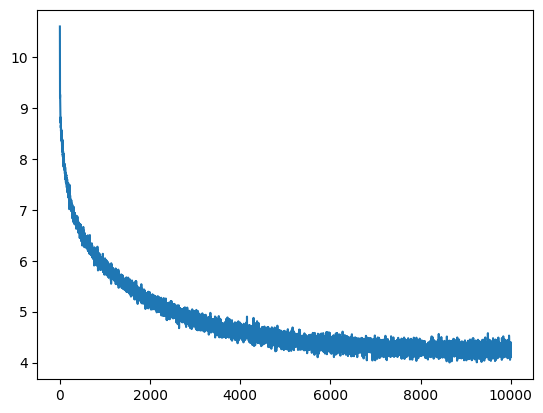

In [37]:
plt.plot(losses);

In [42]:
parameters = dict(alpha = -3, mu = 35, sigma = 2, f = 0.1, beta = 1, gamma = 0)
# parameters = sample_parameters(jax.random.key(np.random.randint(1e6)))
detections = jax.vmap(lambda key: sample_detection(key, parameters))(
    jax.random.split(jax.random.key(np.random.randint(1e6)), num_obs),
)

In [43]:
c = inverse_detections(detections)
x = flow.sample(jax.random.key(4), (10_000,), condition = c)
posterior = jax.vmap(forward_parameters)(x)

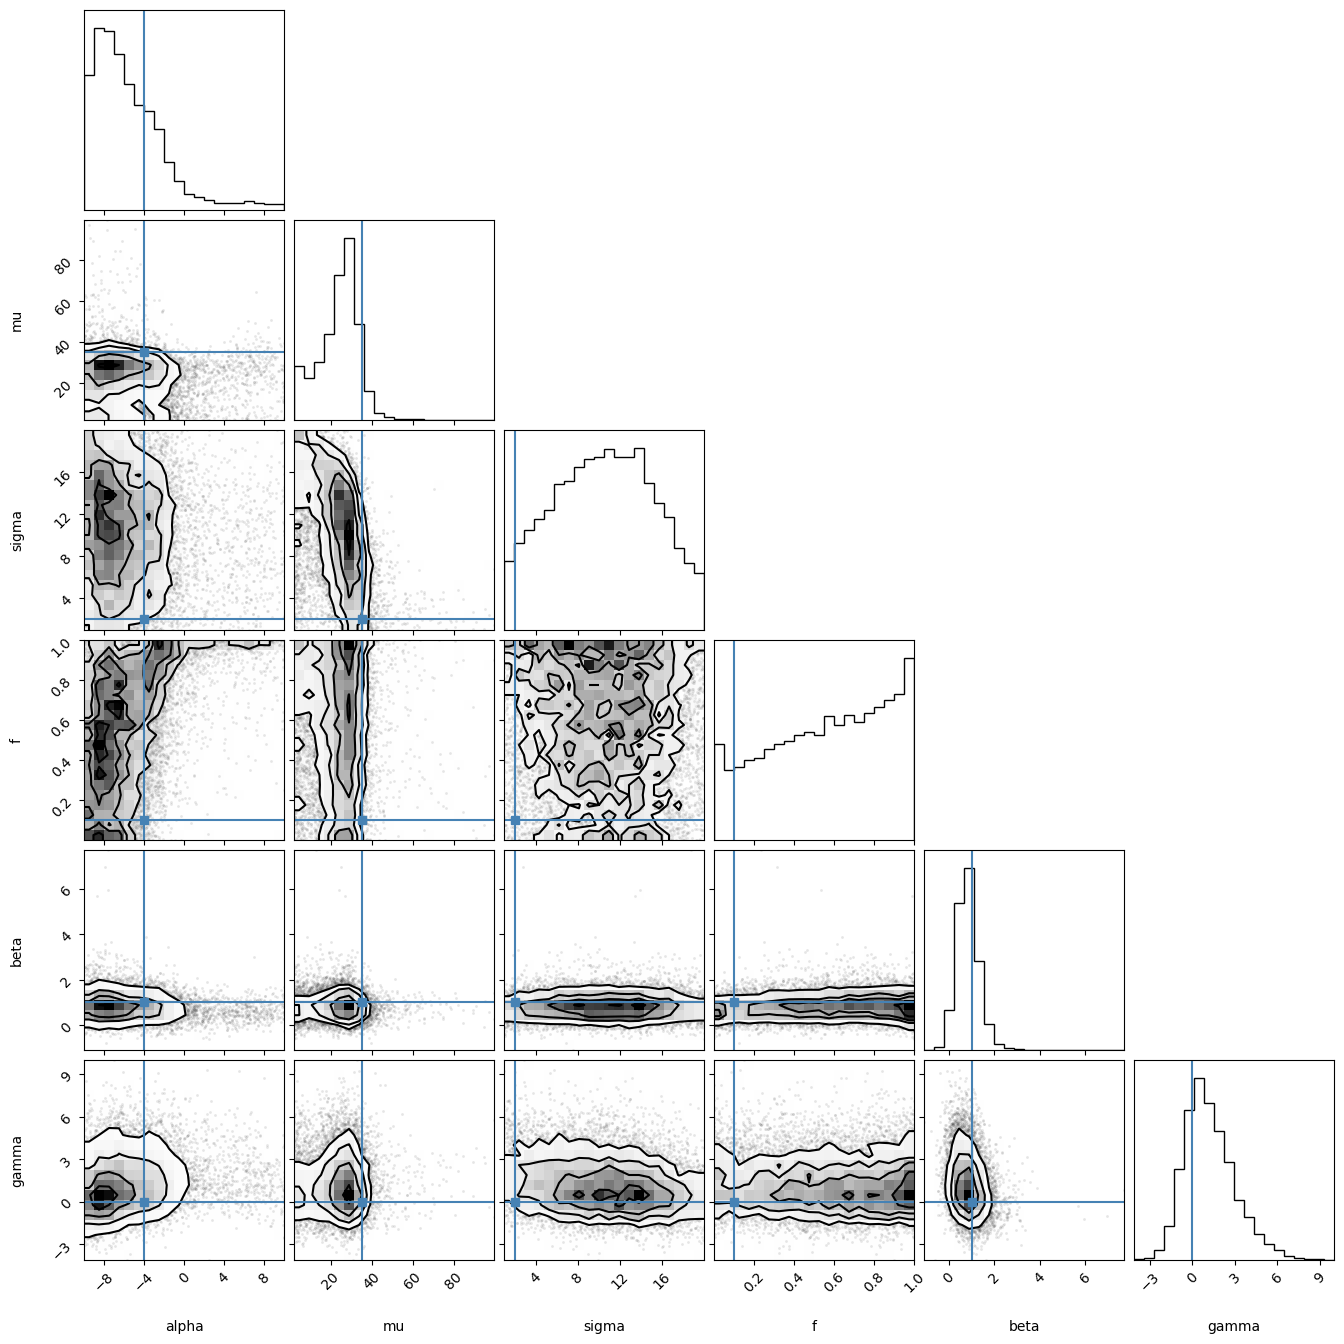

In [44]:
corner(
    np.transpose([posterior[k] for k in priors]),
    labels = list(priors),
    truths = [parameters[k] for k in priors],
);

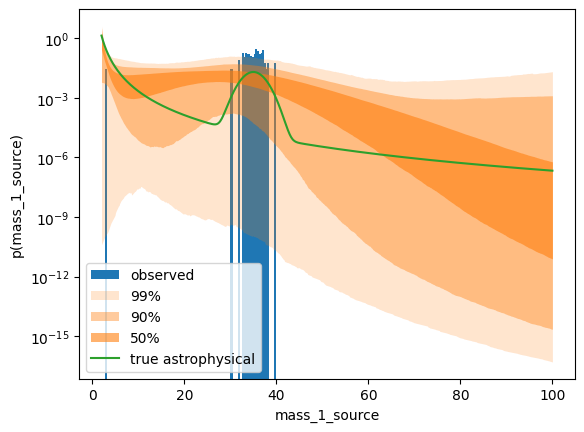

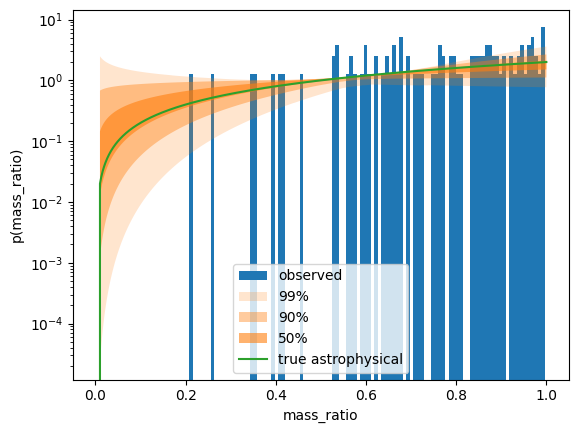

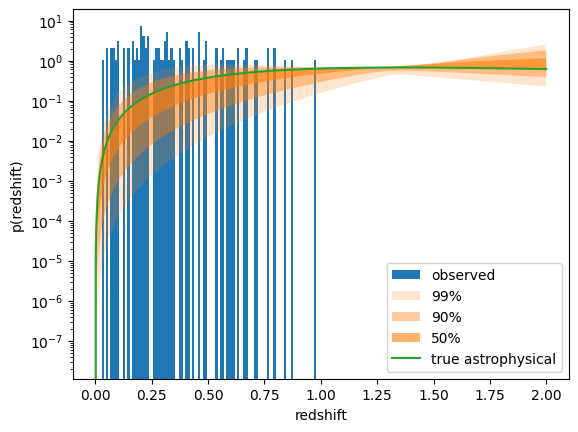

In [45]:
grid = dict(
    mass_1_source = jnp.linspace(2, 100, 1_000),
    mass_ratio = jnp.linspace(0, 1, 1_000),
    redshift = jnp.linspace(0, 2, 1_000),
)

pdf = dict(
    mass_1_source = pdf_m,
    mass_ratio = pdf_q,
    redshift = pdf_z,
)

for k in detections:
    plt.hist(
        detections[k], bins = 100, density = True, label = 'observed',
        color = 'C0',
    )

    ps = jax.vmap(lambda parameters: pdf[k](grid[k], parameters))(posterior)
    for qs, alpha in (
        ((0.005, 0.995), 0.2),
        ((0.05, 0.95), 0.4),
        ((0.25, 0.75), 0.6),
    ):
        label = f'{(qs[1]-qs[0]) * 100:.0f}%'
        plt.fill_between(
            grid[k], *np.quantile(ps, qs, axis = 0), label = label,
            color = 'C1', alpha = alpha, lw = 0,
        )

    plt.plot(
        grid[k], pdf[k](grid[k], parameters), label = 'true astrophysical',
        c = 'C2',
    )

    plt.legend()
    plt.xlabel(k)
    plt.ylabel(f'p({k})')
    plt.semilogy()
    plt.show()

Some suggested homework!
- Try different catalogue sizes.
- Try a more detailed population model.
- Add some other source parameters (e.g., spins) to the population model.
- Try different normalizing flow setups.
- How else might you check the flow posterior is correct?
- We assumed the source parameters are directly observable, which isn't very realistic. What data could you condition the flow on instead?
- How might you make the flow independent of the (currently fixed) catalogue size?